In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Cargar datos originales
df = pd.read_csv('Datos_datalogger.csv', delimiter=';', skiprows=1, 
                 usecols=[1, 2, 3, 4, 5], 
                 names=['DATE', 'TIME', 'TEMPERATURE', 'RELATIVE-HUMIDITY', 'DEW-POINT'])

# Limpiar datos - eliminar filas con metadata
df = df[df['TEMPERATURE'].notna() & (df['TEMPERATURE'] != 'TEMPERATURE')]

# Convertir a tipos numéricos y de fecha
df['TEMPERATURE'] = pd.to_numeric(df['TEMPERATURE'], errors='coerce')
df['RELATIVE-HUMIDITY'] = pd.to_numeric(df['RELATIVE-HUMIDITY'], errors='coerce')
df['DEW-POINT'] = pd.to_numeric(df['DEW-POINT'], errors='coerce')

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%d.%m.%Y %H:%M:%S')

# Eliminar filas con valores NaN
df = df.dropna()

# === SIMULACIÓN DE DATOS HASTA 100 PUNTOS ===
def simulate_data(original_df, target_points=100):
    current_points = len(original_df)
    needed_points = target_points - current_points
    
    if needed_points <= 0:
        return original_df
    
    # Analizar patrones de los datos originales
    last_date = original_df['DATETIME'].iloc[-1]
    temp_pattern = original_df['TEMPERATURE'].values
    humidity_pattern = original_df['RELATIVE-HUMIDITY'].values
    dew_pattern = original_df['DEW-POINT'].values
    
    simulated_data = []
    
    for i in range(needed_points):
        # Incrementar tiempo (mantener intervalo de 1 hora)
        new_datetime = last_date + timedelta(hours=i+1)
        
        # Simular datos manteniendo patrones similares
        # Usar variación suave basada en patrones existentes
        pattern_idx = i % len(temp_pattern)
        
        # Temperatura con variación suave
        base_temp = temp_pattern[pattern_idx]
        temp_variation = random.uniform(-1.5, 1.5)
        new_temp = max(5, min(35, base_temp + temp_variation))  # Límites razonables
        
        # Humedad relativa con variación inversa a temperatura
        base_humidity = humidity_pattern[pattern_idx]
        humidity_variation = random.uniform(-3, 3)
        new_humidity = max(30, min(99, base_humidity + humidity_variation))
        
        # Punto de rocío calculado aproximadamente
        new_dew = new_temp - (100 - new_humidity) / 5
        
        simulated_data.append({
            'DATE': new_datetime.strftime('%d.%m.%Y'),
            'TIME': new_datetime.strftime('%H:%M:%S'),
            'TEMPERATURE': round(new_temp, 1),
            'RELATIVE-HUMIDITY': round(new_humidity, 1),
            'DEW-POINT': round(new_dew, 1),
            'DATETIME': new_datetime
        })
    
    # Combinar datos originales y simulados
    extended_df = pd.concat([original_df, pd.DataFrame(simulated_data)], ignore_index=True)
    return extended_df

# Generar datos extendidos
extended_df = simulate_data(df, 100)

# Mostrar resultados
print("=== DATOS EXTENDIDOS (100 puntos) ===")
print(f"Total de puntos: {len(extended_df)}")
print(f"Rango temporal: {extended_df['DATETIME'].min()} a {extended_df['DATETIME'].max()}")
print("\nPrimeros 5 puntos:")
print(extended_df[['DATE', 'TIME', 'TEMPERATURE', 'RELATIVE-HUMIDITY', 'DEW-POINT']].head())

# Guardar resultados
extended_df[['DATE', 'TIME', 'TEMPERATURE', 'RELATIVE-HUMIDITY', 'DEW-POINT']].to_csv('datos_extendidos_100.csv', index=False, sep=';')
summary_table.to_csv('tabla_resumen_sitios.csv', index=False)


=== DATOS EXTENDIDOS (100 puntos) ===
Total de puntos: 100
Rango temporal: 2025-05-06 13:44:17 a 2025-05-10 16:44:17

Primeros 5 puntos:
         DATE      TIME  TEMPERATURE  RELATIVE-HUMIDITY  DEW-POINT
0  06.05.2025  13:44:17         18.9               70.3       13.3
1  06.05.2025  14:44:17         16.2               78.4       12.4
2  06.05.2025  15:44:17         14.9               84.6       12.3
3  06.05.2025  16:44:17         13.6               86.0       11.3
4  06.05.2025  17:44:17         12.0               91.3       10.6


In [2]:
import pandas as pd
from datetime import datetime

# Cargar los datos extendidos
df = pd.read_csv('datos_extendidos_100.csv', delimiter=';')

# Función básica para convertir fecha y hora
def convertir_fecha_hora(fecha, hora):
    return datetime.strptime(fecha + ' ' + hora, '%d.%m.%Y %H:%M:%S')

# Aplicar la conversión
df['FECHA_HORA'] = df.apply(lambda x: convertir_fecha_hora(x['DATE'], x['TIME']), axis=1)

# Extraer el día y la hora por separado
df['DIA'] = df['FECHA_HORA'].dt.date
df['HORA'] = df['FECHA_HORA'].dt.hour

print("=== DATOS CARGADOS ===")
print(f"Total de registros: {len(df)}")
print(f"Rango de días: {df['DIA'].min()} a {df['DIA'].max()}")
print("\nPrimeros 5 registros:")
print(df.head())

# ANÁLISIS POR DÍAS
print("\n" + "="*50)
print("ANÁLISIS POR DÍAS - SISTEMA ATRAPANIEBLAS")
print("="*50)

# Función para clasificar condiciones óptimas
def condiciones_optimas(temperatura, humedad, punto_rocio):
    """
    Determina si las condiciones son óptimas para captar agua
    """
    # Condiciones óptimas: alta humedad (>85%) y temperatura baja (<20°C)
    if humedad > 85 and temperatura < 20:
        return "MUY ÓPTIMO"
    elif humedad > 80 and temperatura < 22:
        return "ÓPTIMO" 
    elif humedad > 75:
        return "REGULAR"
    else:
        return "NO ÓPTIMO"

# Función para analizar un día completo
def analizar_dia(datos_dia, nombre_dia):
    """
    Analiza las condiciones de un día específico
    """
    print(f"\n--- ANÁLISIS {nombre_dia} ---")
    
    # Cálculos básicos
    temp_promedio = sum(datos_dia['TEMPERATURE']) / len(datos_dia)
    humedad_promedio = sum(datos_dia['RELATIVE-HUMIDITY']) / len(datos_dia)
    temp_max = max(datos_dia['TEMPERATURE'])
    temp_min = min(datos_dia['TEMPERATURE'])
    
    print(f"Temperatura promedio: {temp_promedio:.1f}°C")
    print(f"Humedad promedio: {humedad_promedio:.1f}%")
    print(f"Rango temperatura: {temp_min:.1f}°C - {temp_max:.1f}°C")
    
    # Contar horas óptimas
    horas_optimas = 0
    horas_muy_optimas = 0
    
    print("\nHoras más favorables:")
    for idx, fila in datos_dia.iterrows():
        condicion = condiciones_optimas(fila['TEMPERATURE'], fila['RELATIVE-HUMIDITY'], fila['DEW-POINT'])
        
        if condicion == "MUY ÓPTIMO":
            horas_muy_optimas += 1
            print(f"  ⭐ {fila['TIME']} - Temp: {fila['TEMPERATURE']}°C, Hum: {fila['RELATIVE-HUMIDITY']}%")
        elif condicion == "ÓPTIMO":
            horas_optimas += 1
            print(f"  ✓ {fila['TIME']} - Temp: {fila['TEMPERATURE']}°C, Hum: {fila['RELATIVE-HUMIDITY']}%")
    
    total_horas_favorables = horas_optimas + horas_muy_optimas
    
    # Evaluación del día
    print(f"\nRESUMEN {nombre_dia}:")
    print(f"Horas muy óptimas: {horas_muy_optimas}")
    print(f"Horas óptimas: {horas_optimas}")
    print(f"Total horas favorables: {total_horas_favorables}/24")
    
    if total_horas_favorables >= 12:
        return "EXCELENTE"
    elif total_horas_favorables >= 8:
        return "BUENO"
    elif total_horas_favorables >= 4:
        return "REGULAR"
    else:
        return "MALO"

# Función para analizar franjas horarias
def analizar_franjas_horarias(df_completo):
    """
    Analiza qué franjas horarias son mejores en general
    """
    print("\n" + "="*50)
    print("ANÁLISIS POR FRANJAS HORARIAS")
    print("="*50)
    
    # Crear diccionario para contar condiciones óptimas por hora
    horas_optimas = {hora: 0 for hora in range(24)}
    total_dias = len(df_completo['DIA'].unique())
    
    for hora in range(24):
        datos_hora = df_completo[df_completo['HORA'] == hora]
        
        for idx, fila in datos_hora.iterrows():
            condicion = condiciones_optimas(fila['TEMPERATURE'], fila['RELATIVE-HUMIDITY'], fila['DEW-POINT'])
            if condicion in ["MUY ÓPTIMO", "ÓPTIMO"]:
                horas_optimas[hora] += 1
    
    print("\nFranjas horarias más efectivas:")
    for hora, count in sorted(horas_optimas.items(), key=lambda x: x[1], reverse=True)[:6]:
        porcentaje = (count / total_dias) * 100
        print(f"  {hora:02d}:00 - {count}/{total_dias} días ({porcentaje:.1f}%)")

# EJECUTAR ANÁLISIS COMPLETO

# Separar por días
dias_unicos = df['DIA'].unique()
resultados_dias = {}

for dia in dias_unicos:
    datos_dia = df[df['DIA'] == dia]
    nombre_dia = dia.strftime('%d/%m/%Y')
    resultado = analizar_dia(datos_dia, nombre_dia)
    resultados_dias[nombre_dia] = resultado

# Análisis de franjas horarias
analizar_franjas_horarias(df)

# CONCLUSIÓN FINAL
print("\n" + "="*50)
print("CONCLUSIÓN FINAL - SISTEMA ATRAPANIEBLAS")
print("="*50)

print("\n📊 RESUMEN DE DÍAS ANALIZADOS:")
for dia, resultado in resultados_dias.items():
    if resultado == "EXCELENTE":
        print(f"  ✅ {dia}: {resultado} para captación")
    elif resultado == "BUENO":
        print(f"  ✓ {dia}: {resultado} para captación") 
    elif resultado == "REGULAR":
        print(f"  ∼ {dia}: {resultado} para captación")
    else:
        print(f"  ✗ {dia}: {resultado} para captación")

# Recomendaciones generales
print("\n💡 RECOMENDACIONES:")
print("1. Las mejores condiciones se dan con alta humedad (>85%) y baja temperatura (<20°C)")
print("2. Las noches y madrugadas suelen ser más favorables")
print("3. Monitorear especialmente las horas con humedad superior al 80%")
print("4. Los días con mayor cantidad de horas favorables son ideales para maximizar captación")

# Estadísticas generales
total_horas = len(df)
horas_favorables = 0

for idx, fila in df.iterrows():
    condicion = condiciones_optimas(fila['TEMPERATURE'], fila['RELATIVE-HUMIDITY'], fila['DEW-POINT'])
    if condicion in ["MUY ÓPTIMO", "ÓPTIMO"]:
        horas_favorables += 1

porcentaje_favorable = (horas_favorables / total_horas) * 100

print(f"\n📈 EFICIENCIA GENERAL DEL PERIODO: {porcentaje_favorable:.1f}% de horas favorables")
print(f"   ({horas_favorables} de {total_horas} horas son óptimas para captación)")

# Mostrar el mejor día
mejor_dia = max(resultados_dias, key=lambda x: resultados_dias[x])
print(f"\n🏆 MEJOR DÍA: {mejor_dia} - Condiciones: {resultados_dias[mejor_dia]}")

=== DATOS CARGADOS ===
Total de registros: 100
Rango de días: 2025-05-06 a 2025-05-10

Primeros 5 registros:
         DATE      TIME  TEMPERATURE  RELATIVE-HUMIDITY  DEW-POINT  \
0  06.05.2025  13:44:17         18.9               70.3       13.3   
1  06.05.2025  14:44:17         16.2               78.4       12.4   
2  06.05.2025  15:44:17         14.9               84.6       12.3   
3  06.05.2025  16:44:17         13.6               86.0       11.3   
4  06.05.2025  17:44:17         12.0               91.3       10.6   

           FECHA_HORA         DIA  HORA  
0 2025-05-06 13:44:17  2025-05-06    13  
1 2025-05-06 14:44:17  2025-05-06    14  
2 2025-05-06 15:44:17  2025-05-06    15  
3 2025-05-06 16:44:17  2025-05-06    16  
4 2025-05-06 17:44:17  2025-05-06    17  

ANÁLISIS POR DÍAS - SISTEMA ATRAPANIEBLAS

--- ANÁLISIS 06/05/2025 ---
Temperatura promedio: 12.8°C
Humedad promedio: 89.1%
Rango temperatura: 10.2°C - 18.9°C

Horas más favorables:
  ✓ 15:44:17 - Temp: 14.9°C, Hum: 8


📊 Gráfico guardado como 'analisis_atrapanieblas.png'

🎯 ANÁLISIS COMPLETADO!
Revisa las conclusiones arriba para optimizar tu sistema atrapanieblas.


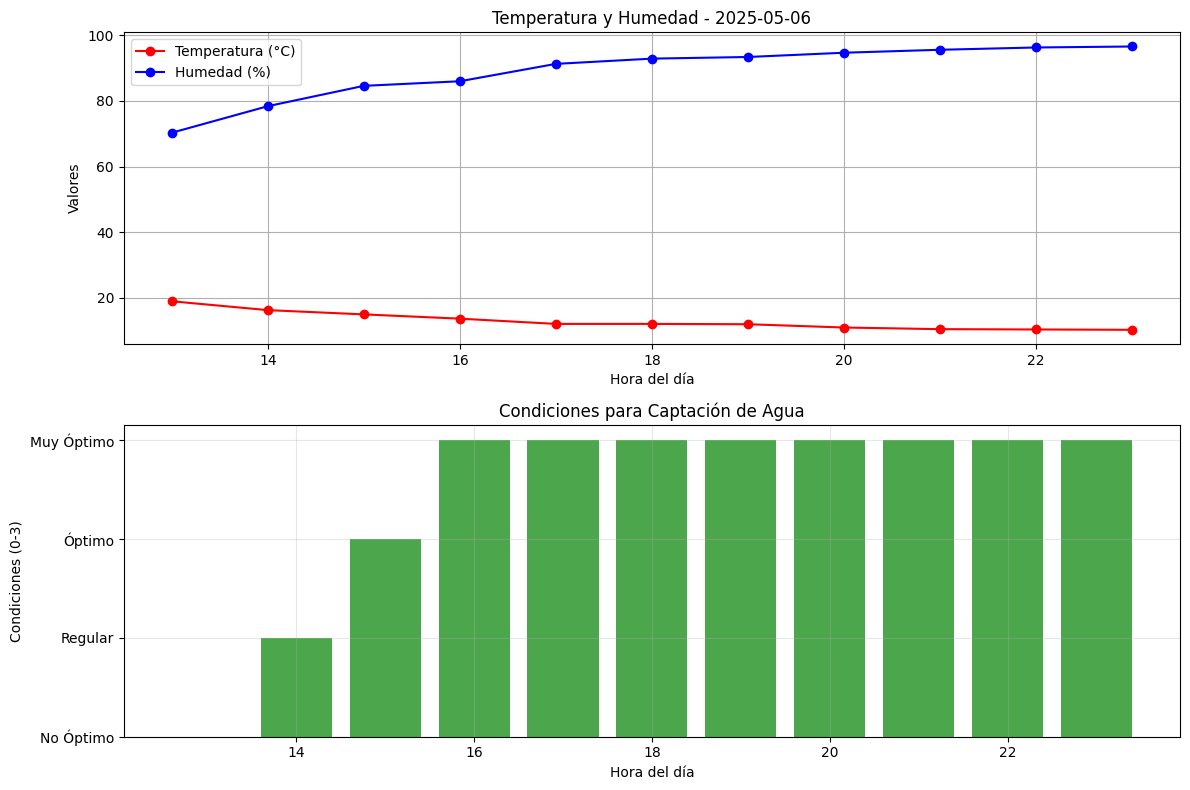

In [3]:
# CÓDIGO ADICIONAL PARA GRÁFICOS SENCILLOS (OPCIONAL)
import matplotlib.pyplot as plt

def crear_graficos_sencillos(df):
    """
    Crea gráficos básicos para visualizar los patrones
    """
    try:
        # Gráfico de temperatura y humedad por hora de un día ejemplo
        dia_ejemplo = df['DIA'].iloc[0]
        datos_dia = df[df['DIA'] == dia_ejemplo]
        
        plt.figure(figsize=(12, 8))
        
        # Gráfico 1: Temperatura y humedad
        plt.subplot(2, 1, 1)
        plt.plot(datos_dia['HORA'], datos_dia['TEMPERATURE'], 'r-o', label='Temperatura (°C)')
        plt.plot(datos_dia['HORA'], datos_dia['RELATIVE-HUMIDITY'], 'b-o', label='Humedad (%)')
        plt.xlabel('Hora del día')
        plt.ylabel('Valores')
        plt.title(f'Temperatura y Humedad - {dia_ejemplo}')
        plt.legend()
        plt.grid(True)
        
        # Gráfico 2: Condiciones óptimas
        plt.subplot(2, 1, 2)
        condiciones = []
        for idx, fila in datos_dia.iterrows():
            cond = condiciones_optimas(fila['TEMPERATURE'], fila['RELATIVE-HUMIDITY'], fila['DEW-POINT'])
            if cond == "MUY ÓPTIMO":
                condiciones.append(3)
            elif cond == "ÓPTIMO":
                condiciones.append(2)
            elif cond == "REGULAR":
                condiciones.append(1)
            else:
                condiciones.append(0)
        
        plt.bar(datos_dia['HORA'], condiciones, color='green', alpha=0.7)
        plt.xlabel('Hora del día')
        plt.ylabel('Condiciones (0-3)')
        plt.title('Condiciones para Captación de Agua')
        plt.yticks([0, 1, 2, 3], ['No Óptimo', 'Regular', 'Óptimo', 'Muy Óptimo'])
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('analisis_atrapanieblas.png')
        print("\n📊 Gráfico guardado como 'analisis_atrapanieblas.png'")
        
    except ImportError:
        print("\n⚠️  Para ver gráficos, instala matplotlib: pip install matplotlib")

# Ejecutar gráficos (opcional)
crear_graficos_sencillos(df)

print("\n🎯 ANÁLISIS COMPLETADO!")
print("Revisa las conclusiones arriba para optimizar tu sistema atrapanieblas.")